### Tasks
* Implement Faiss - (create a util file using code given by gaurav and import here) 
* Implement Near Neighbor Sampling 
* plot the gradients for each batch (==1, should be high) and for the entire dataset(should be low) at different interesting epochs 
* Figure out how to calculate efficient per sample gradient 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import time

#replace with pytorch lightning
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle

from ipywidgets import FloatProgress

from indx import *
from query import *

In [2]:
random.seed(123)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
df=pd.read_csv("HIGGS.csv",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [5]:
#subsample
# df = df[:600000]

In [6]:
print(df.size)

319000000


<AxesSubplot: xlabel='0', ylabel='count'>

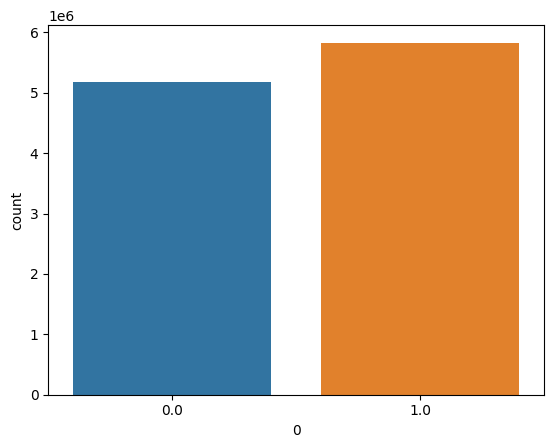

In [7]:
sns.countplot(x = 0, data=df)

In [8]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [9]:
EPOCHS = 15
BATCH_SIZE = 1024
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 2
K=10
MAX_STEPS=1000
FLAG=True
NPROBE=10
NQUERIES=100
METRIC=" INNER-PRODUCT-2"

In [10]:
# wandb.init(project="my-test-project", config=config)

In [11]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [13]:
faiss.get_num_gpus()

8

In [14]:
#split training data into two subarrays based on class
X_train_class=[]
for i in range(NUM_CLASSES):
    X_train_class.append(np.ascontiguousarray(X_train[y_train == i]))
print(X_train_class[0].shape)
# #Create Faiss index for each class
# index(X_train_class[0],"IVF20480,PQ28","CLASS0")
# index(X_train_class[1],"IVF20480,PQ28","CLASS1")


(3723032, 28)


In [15]:
def get_class_distribution(obj):
    count_dict = {
        "class_0": 0,
        "class_1": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['class_0'] += 1
        elif i == 1: 
            count_dict['class_1'] += 1           
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

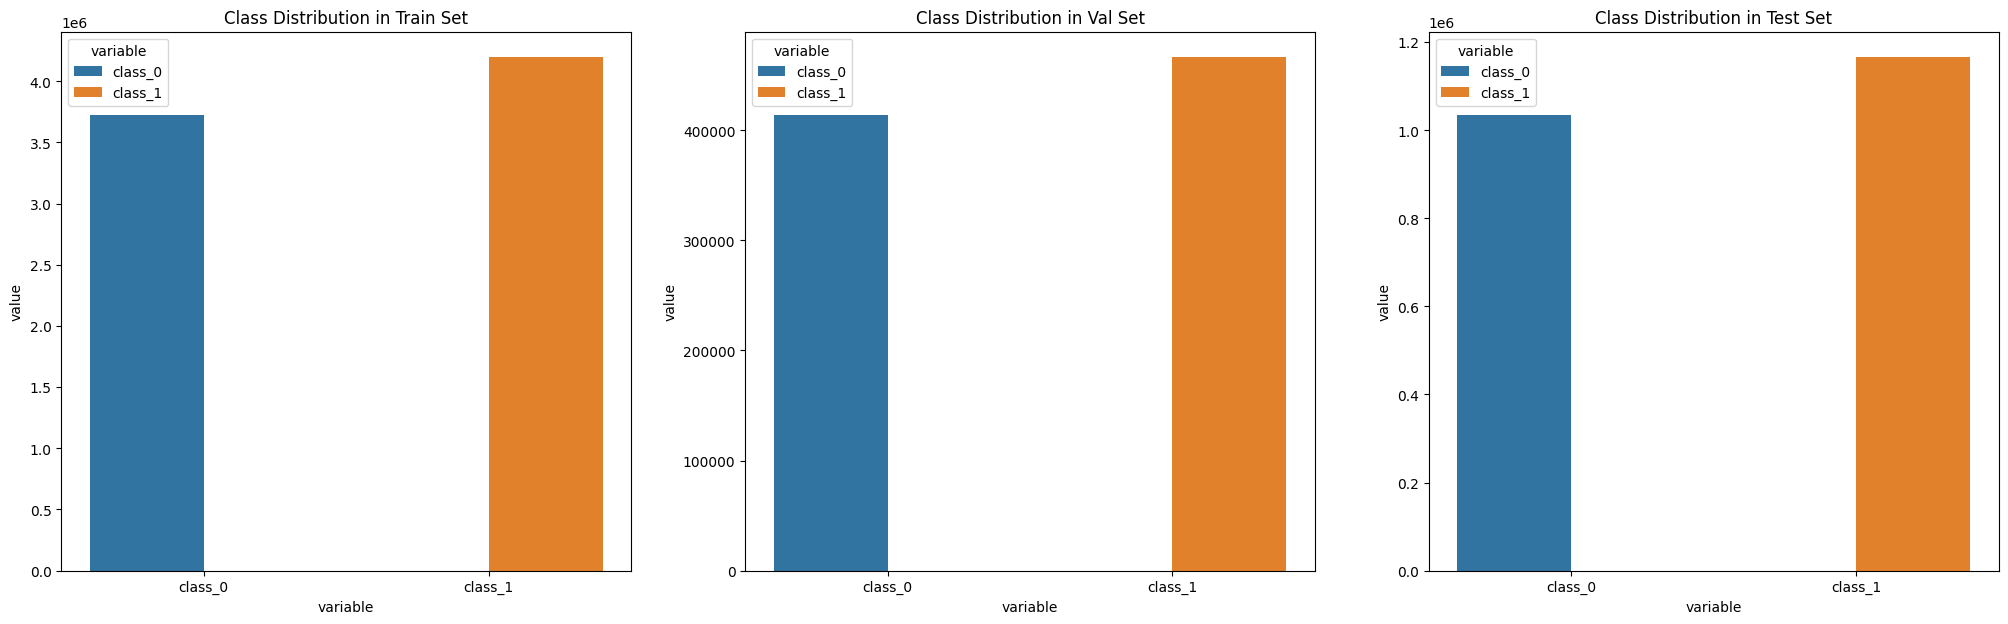

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [17]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [18]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)

In [19]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)

tensor([2.6860e-07, 2.3827e-07])


In [20]:
class_weights_all = class_weights[target_list]

In [21]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [22]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=16384)
val_loader = DataLoader(dataset=val_dataset, batch_size=16384)
test_loader = DataLoader(dataset=test_dataset, batch_size=16384)

In [23]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 512)
        self.layer_3 = nn.Linear(512, 512)
        self.layer_out = nn.Linear(512, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(512)
        self.batchnorm3 = nn.BatchNorm1d(512)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [24]:
import torch
from torch import autograd
from torch import nn


class CrossEntropyLoss(nn.Module):
    """
    This criterion (`CrossEntropyLoss`) combines `LogSoftMax` and `NLLLoss` in one single class.
    
    NOTE: Computes per-element losses for a mini-batch (instead of the average loss over the entire mini-batch).
    """
    log_softmax = nn.LogSoftmax()

    def __init__(self):
        super().__init__()
        
    def forward(self, x, target):
        log_softmax =  x - x.exp().sum(-1).log().unsqueeze(-1)
        loss = -log_softmax[range(target.shape[0]), target]
        return loss.mean(), loss.argsort()

In [25]:
#COMMENTED THIS BECAUSE THEY NEED TO BE REINITIALISED FOR EVERY RUN, SHIFTED THIS INSIDE TRAINING_CUSTOM FUNCTION
# model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
# model.to(device)

# criterion = CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# print(model)

In [26]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [27]:
def faissQuery(X_train_class, Queries,nprobe,nqueries):
    tempbatch=set()
    for i in range(NUM_CLASSES):
        distance, bucket = query(X_train_class[i].shape[1],X_train_class[i].shape[0],len(Queries[i]),False,np.array(Queries[i].cpu()),np.array(Queries[i].cpu()),f'CLASS{i}',nprobe,nqueries)
        for j in range(len(bucket)):
            for k in range(len(bucket[j])):
                #print("Class: ", i)
                #print("Query: ", Queries[i][j])
                #print("Neighbor: ", X_train_class[i][int(bucket[j][k])])
                tempbatch.add((int(bucket[j][k]),i))
    return tempbatch

In [28]:
#random_size is controlling the randomness in batch creation, random_size=0 means 100% random samples
#random_size=BATCH_SIZE/2 means 50% random samples and 50% LSH samples.
#so random_size should be set as per the BATCH_SIZE such that BATCH_SIZE-random_size)/2 is Integer
def createBatch(tempbatch,random_size=0):
    tempbatch=list(tempbatch)
    LSHbatch=random.choices(tempbatch, k=random_size)
    batchX = [X_train_class[x[1]][x[0]] for x in LSHbatch]
    batchY = [x[1] for x in LSHbatch]
    randomBatch0 = random.choices(X_train_class[0], k=int((BATCH_SIZE-random_size)/2))
    randomBatch1 = random.choices(X_train_class[1], k=int((BATCH_SIZE-random_size)/2))
    if random_size!=0:
        batchX = np.concatenate((batchX, randomBatch0, randomBatch1))
        batchY= np.concatenate((batchY, [0]*int((BATCH_SIZE-random_size)/2), [1]*int((BATCH_SIZE-random_size)/2)))
    else:
        batchX = np.concatenate((randomBatch0, randomBatch1))
        batchY= np.concatenate(([0]*int(BATCH_SIZE/2), [1]*int(BATCH_SIZE/2)))
    
    batchX, batchY = shuffle(batchX, batchY)
    
    return np.array(batchX), np.array(batchY).astype(np.int64)

In [29]:
temp_indices=list(range(0,len(X_train)))
temp_indices=random.choices(temp_indices,k=BATCH_SIZE)

In [30]:
#initializing the model
model=model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
torch.save(model.state_dict(), 'model_weights_init2.pth')

In [31]:
#create constant train and validation batches


In [33]:
# config = {
#   "learning_rate": LEARNING_RATE,
#   "epochs": EPOCHS,
#   "batch_size": BATCH_SIZE,
#   "classes":NUM_CLASSES,
#   "TopK":K,
#   "Max_Steps":MAX_STEPS,
#   "Data Points":600000,
#   "LSH_BATCH":FLAG,
#   "NPROBE": NPROBE,
#   "NQUERIES": NQUERIES,
#   "METRIC": INNER_PRODUCT
# }

#CREATING THE SWEEP CONFIG
sweep_config = {
    'method': 'grid',
    'name': 'INIT-2'
    }

parameters_dict = {
    "LEARNING_RATE": {
        'value': 0.0007
        },
    "NUM_FEATURES": {
        'value': NUM_FEATURES
        },
    "NUM_CLASSES": {
        'value': NUM_CLASSES
        },
    "EPOCHS": {
        'value': EPOCHS
        },
    "BATCH_SIZE": {
        'value': BATCH_SIZE
        },
    "TopK": {
        'value': 10
        },
    "MAX_STEPS": {
        'value': MAX_STEPS
        },
    "Data_Points": {
        'value': 319000000
        },
    "LSH_BATCH": {
        'value': FLAG
        },
    "NPROBE": {
        'value': 20
        },
    "NQUERIES": {
        'value': 100
        },
    "METRIC": {
        'value': METRIC
        },
    "RANDOM_SIZE":{
        'values':[0,102,204,308,410,512]
        },
    }

sweep_config['parameters'] = parameters_dict

sweep_id = wandb.sweep(sweep_config, project="InnerProduct-Fulldata-sweeps-INIT-2")

Create sweep with ID: olnzxhlg
Sweep URL: https://wandb.ai/lsh_batches/InnerProduct-Fulldata-sweeps-INIT-2/sweeps/olnzxhlg


In [36]:
for x,y in train_loader:
    print(x.dtype, y.dtype)
    break
x2, y2 = next(iter(train_loader))
print(x2.dtype, y2.dtype)

torch.float32 torch.int64
torch.float32 torch.int64


In [37]:
LSHBatching=True

In [38]:
def training_custom(config=None):
    # INITIALIZE NEW WANDB RUN
#     X_val_batch, y_val_batch = next(iter(val_loader))
#     X_train_batch, y_train_batch = next(iter(train_loader))
    with wandb.init(config=config) as run:
        #USING THE CONFIG TO SET THE HYPERPARAMETERS FOR EACH RUN
        config = wandb.config
        run.name = "Random-Size-"+str(config.RANDOM_SIZE)
        print("Begin training.")
        #INITIALIZE NEW MODEL FOR EVERY RUN
        model = MulticlassClassification(num_feature = config.NUM_FEATURES, num_class=config.NUM_CLASSES)
        model.load_state_dict(torch.load('model_weights_init2.pth'))
        model.to(device)

        criterion = CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
        
        oldBatch = set()
        #INITIALIZE STATS FOR EVERY RUN
        accuracy_stats = {
            'train': [],
            "val": []
        }
        loss_stats = {
            'train': [],
            "val": []
        }
        #FIRST BATCH FOR EVERY RUN SHOULD BE THE SAME, TEMP_INDICES HAS BEEN RUN ONCE AND WILL BE USED EVERYTIME
        X_train_LSH=X_train[temp_indices]
        y_train_LSH=y_train[temp_indices].astype(np.int64)
        
        for e in tqdm(range(1, config.EPOCHS)):
            # TRAINING
            model.train()
            step=0
            for steps in tqdm(range(1, config.MAX_STEPS+1)):
                X_train_batch= torch.from_numpy(X_train_LSH).to(device)
                y_train_batch=torch.from_numpy(y_train_LSH).to(device)

                ##why ? 
                optimizer.zero_grad()

                #timestampA = time.time()
                y_train_pred = model(X_train_batch.float())
                #print("Time for pred", time.time() - timestampA)

                #timestampB = time.time()

                train_loss, sorted_index = criterion(y_train_pred, y_train_batch)
                #print("Time for loss", time.time() - timestampB)

                if LSHBatching:
                    #PROCEDURE FOR NEW BATCHES
                    with torch.no_grad():
                        #Find elements in batch that led to top K losses  
                        X_train_batch_Topk = X_train_batch[sorted_index[-config.TopK:]]
                        y_train_batch_Topk = y_train_batch[sorted_index[-config.TopK:]]

                        #Query Faiss for nearest neighbors
                        #timestampC = time.time()
                        nextBatch = faissQuery(X_train_class,[X_train_batch_Topk[y_train_batch_Topk == 0], X_train_batch_Topk[y_train_batch_Topk == 1]],config.NPROBE,config.NQUERIES)
                        #print("Time for faiss query", time.time() - timestampC)

                        #check for being stuck in cluster  
                        #print("Similarity to old batch", len(nextBatch.intersection(oldBatch))/len(nextBatch.union(oldBatch)))
                        oldBatch = nextBatch

                        # Create new batch from neighbors and random sample
                        #timestampD = time.time()
                        X_train_LSH,y_train_LSH=createBatch(nextBatch,config.RANDOM_SIZE)
                        #print("Time for batch creation", time.time() - timestampD)

                else:
                    with torch.no_grad():
                        X_train_LSH,y_train_LSH=createBatch(X_train_batch)
                ##############################


                train_loss.backward()

                optimizer.step()



            with torch.no_grad():
                val_epoch_loss = 0
                val_epoch_acc = 0
                train_epoch_loss=0
                train_epoch_acc=0
                model.eval()
                
                # VALIDATION LOSS AND ACCURACY
                for X_val_batch, y_val_batch in val_loader:
                    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                    y_val_pred = model(X_val_batch)

                    val_loss, _ = criterion(y_val_pred, y_val_batch)
                    val_acc = multi_acc(y_val_pred, y_val_batch)

                    val_epoch_loss += val_loss.item()
                    val_epoch_acc += val_acc.item()
                    break
                
                
                # TRAIN LOSS AND ACCURACY
                for X_train_batch, y_train_batch in train_loader:
                    X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
                    y_train_pred = model(X_train_batch)

                    train_loss, _ = criterion(y_train_pred, y_train_batch)
                    train_acc = multi_acc(y_train_pred, y_train_batch)

                    train_epoch_loss += train_loss.item()
                    train_epoch_acc += train_acc.item()
                    break

            loss_stats['train'].append(train_epoch_loss)
            loss_stats['val'].append(val_epoch_loss)
            accuracy_stats['train'].append(train_epoch_acc)
            accuracy_stats['val'].append(val_epoch_acc)


            
            print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss:.5f} | Val Loss: {val_epoch_loss:.5f} | Train Acc: {train_epoch_acc:.3f}| Val Acc: {val_epoch_acc:.3f}')
            #LOGGING LOSS AND ACCURACY TO WANDB
            wandb.log({"Train Loss":train_epoch_loss, "Val Loss":val_epoch_loss,"Train Accuracy":train_epoch_acc,"Val Accuracy":val_epoch_acc}, step=e)

In [ ]:
#SWEEPING OVER THE HYPERPARAMETERS
wandb.agent(sweep_id, training_custom)
#NO NEED TO RUN ANYTHING BEYOND THIS CELL

wandb: Agent Starting Run: 7dkg3dup with config:
wandb: 	BATCH_SIZE: 1024
wandb: 	Data_Points: 319000000
wandb: 	EPOCHS: 15
wandb: 	LEARNING_RATE: 0.0007
wandb: 	LSH_BATCH: True
wandb: 	MAX_STEPS: 1000
wandb: 	METRIC:  INNER-PRODUCT-2
wandb: 	NPROBE: 20
wandb: 	NQUERIES: 100
wandb: 	NUM_CLASSES: 2
wandb: 	NUM_FEATURES: 28
wandb: 	RANDOM_SIZE: 0
wandb: 	TopK: 10
wandb: Currently logged in as: aw82 (lsh_batches). Use `wandb login --relogin` to force relogin


Begin training.


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.58603 | Val Loss: 0.58909 | Train Acc: 69.000| Val Acc: 68.000


  0%|          | 0/1000 [00:00<?, ?it/s]

In [52]:

# print("Begin training.")
# for e in tqdm(range(1, EPOCHS+1)):

#   # TRAINING
#   train_epoch_loss = 0
#   train_epoch_acc = 0
#   model.train()
#   for X_train_batch, y_train_batch in train_loader:
#       X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
#       optimizer.zero_grad()
#       y_train_pred = model(X_train_batch)

#       train_loss, _ = criterion(y_train_pred, y_train_batch)
#       train_acc = multi_acc(y_train_pred, y_train_batch)


#       train_loss.backward()
#       optimizer.step()

#       train_epoch_loss += train_loss.item()
#       train_epoch_acc += train_acc.item()


#   # VALIDATION    
#   with torch.no_grad():

#       val_epoch_loss = 0
#       val_epoch_acc = 0

#       model.eval()
#       for X_val_batch, y_val_batch in val_loader:
#           X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

#           y_val_pred = model(X_val_batch)

#           val_loss, _ = criterion(y_val_pred, y_val_batch)
#           val_acc = multi_acc(y_val_pred, y_val_batch)

#           val_epoch_loss += val_loss.item()
#           val_epoch_acc += val_acc.item()
#   loss_stats['train'].append(train_epoch_loss/len(train_loader))
#   loss_stats['val'].append(val_epoch_loss/len(val_loader))
#   accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
#   accuracy_stats['val'].append(val_epoch_acc/len(val_loader))


#   print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')

In [152]:
%pdb off

Automatic pdb calling has been turned OFF


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

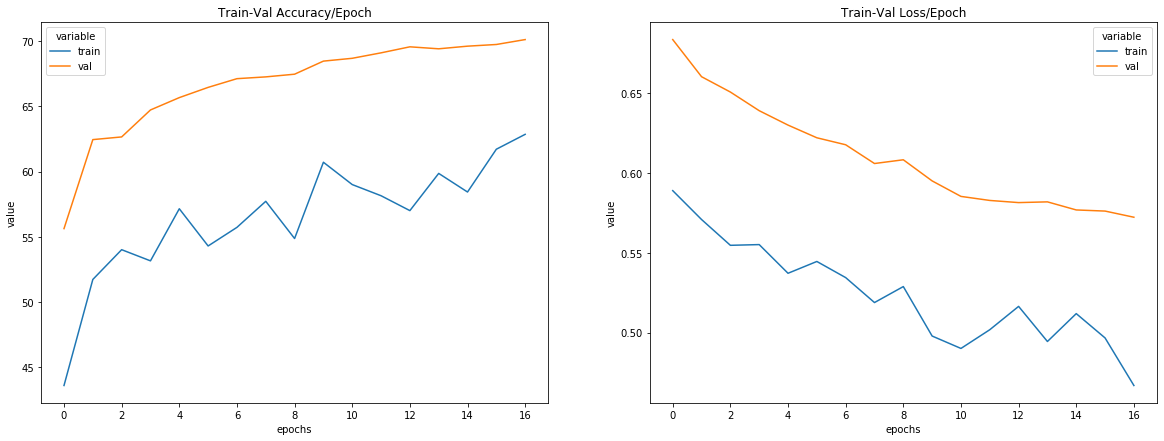

In [34]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

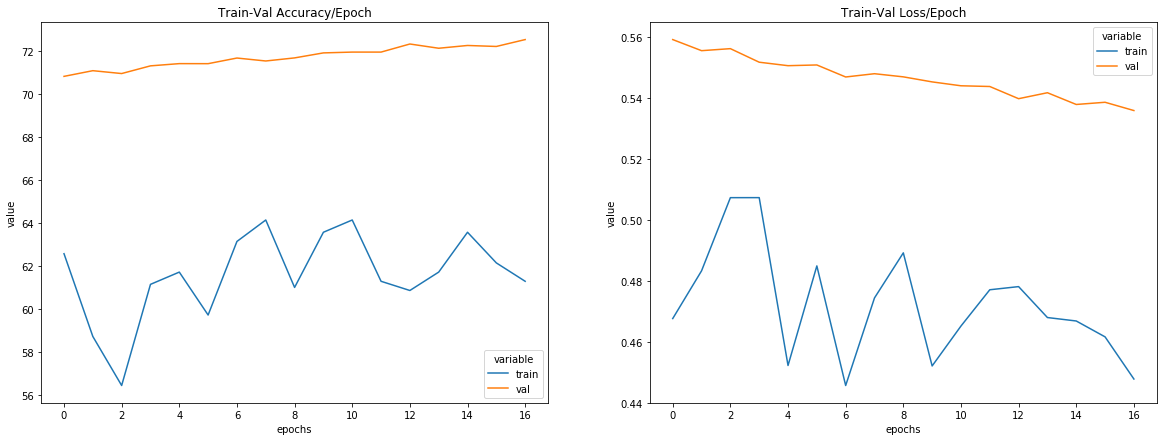

In [39]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

In [184]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [185]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

NameError: name 'idx2class' is not defined

In [ ]:
print(classification_report(y_test, y_pred_list))